In [ ]:
# If widgets don't show, uncomment and run these two lines once:
# !pip install ipywidgets
# from google.colab import output; output.enable_custom_widget_manager()

import numpy as np
from ipywidgets import Button, GridBox, Layout, VBox, HBox, Label
from IPython.display import display
from google.colab import files

# ===== CONFIG =====
GRID_HEIGHT = 35   # tiles vertically
GRID_WIDTH  = 29   # tiles horizontally
MIF_FILENAME = "tiles.mif"

# Grid data: 0 = unselected, 1 = selected
grid = np.zeros((GRID_HEIGHT, GRID_WIDTH), dtype=int)

# Store button widgets in same shape
buttons = [[None for _ in range(GRID_WIDTH)] for _ in range(GRID_HEIGHT)]

tile_size = "20px"  # visual tile size


def make_tile_button(r, c):
    """
    Create a toggle-like button for tile (r, c).
    """
    btn = Button(
        description="",
        layout=Layout(width=tile_size, height=tile_size, padding="0"),
    )
    btn.style.button_color = "white"  # start as 0

    def on_click(b, row=r, col=c):
        # Toggle grid value
        grid[row, col] = 1 - grid[row, col]
        # Update color
        if grid[row, col] == 1:
            b.style.button_color = "black"
        else:
            b.style.button_color = "white"

    btn.on_click(on_click)
    return btn


# Create all tile buttons
flat_children = []
for r in range(GRID_HEIGHT):
    for c in range(GRID_WIDTH):
        btn = make_tile_button(r, c)
        buttons[r][c] = btn
        flat_children.append(btn)

# Layout grid using CSS grid
grid_layout = Layout(
    width="auto",
    grid_template_columns=(" ".join(["auto"] * GRID_WIDTH)),
    grid_template_rows=(" ".join(["auto"] * GRID_HEIGHT)),
    grid_gap="1px"
)

grid_box = GridBox(children=flat_children, layout=grid_layout)


def write_mif(filename, grid_data): # Modified to accept grid_data
    """
    Write current grid to a 1-bit MIF file.
    Address order: row-major (top to bottom, left to right).
    """
    depth = GRID_HEIGHT * GRID_WIDTH
    width = 1  # 1 bit per tile

    with open(filename, "w") as f:
        f.write(f"DEPTH = {depth};\n")
        f.write(f"WIDTH = {width};\n")
        f.write("ADDRESS_RADIX = DEC;\n")
        f.write("DATA_RADIX = HEX;\n")
        f.write("CONTENT BEGIN\n")

        addr = 0
        for row in range(GRID_HEIGHT):
            for col in range(GRID_WIDTH):
                value = int(grid_data[row, col])   # Use grid_data instead of global grid
                f.write(f"    {addr} : {value:X};\n")
                addr += 1

        f.write("END;\n")

    print(f"[DONE] Wrote {depth} entries to {filename}")


status_label = Label(value="Click tiles to draw. When done, press 'Save MIF'.")

save_button = Button(
    description="Save MIF",
    button_style="success",
    layout=Layout(width="120px", height="32px")
)

def on_save_clicked(b):
    status_label.value = "Saving MIF..."
    write_mif(MIF_FILENAME, grid) # Modified to pass the global 'grid' variable
    # Trigger download in Colab
    files.download(MIF_FILENAME)
    status_label.value = f"Saved and ready to download: {MIF_FILENAME}"

save_button.on_click(on_save_clicked)

ui = VBox([
    status_label,
    grid_box,
    HBox([save_button])
])

display(ui)

Upload an image:


Saving map snipped.png to map snipped (4).png
[INFO] Loaded: map snipped (4).png
[INFO] Original size: (705, 851), resizing to (w=29, h=35)
[INFO] Grid shape: (35, 29)


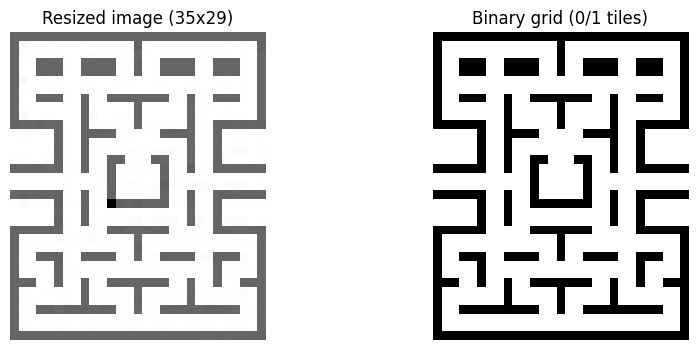


[GRID 0/1 PREVIEW] (truncated if too wide)
11111111111111111111111111111
10000000000000100000000000001
10000000000000100000000000001
10011100111100100111100111001
10011100111100100111100111001
10000000000000000000000000001
10000000000000000000000000001
10011100100111111100100111001
10000000100000100000100000001
10000000100000100000100000001
11111100100000100000100111111
00000100111100000111100100000
00000100100000000000100100000
00000100100000000000100100000
00000100100110001100100100000
11111100100100000100100111111
00000000000100000100000000000
00000000000100000100000000000
11111100100100000100100111111
00000100100111111100100100000
00000100100000000000100100000
00000100100000000000100100000
11111100000111111100000111111
10000000000000100000000000001
10000000000000100000000000001
10011100111100100111100111001
10000100000000000000000100001
10000100000000000000000100001
11100100100111111100100100111
10000000100000100000100000001
10000000100000100000100000001
10011111111100100111111111

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# ===== CONFIG =====
GRID_HEIGHT = 35        # number of tiles vertically
GRID_WIDTH  = 29        # number of tiles horizontally
THRESHOLD   = 130       # 0–255: lower = darker => 1, higher = lighter => 1 (see INVERT)
INVERT      = False     # False: dark = 1, light = 0; True: dark = 0, light = 1
MIF_FILENAME = "tiles.mif"

# ===== STEP 1: Upload image =====
print("Upload an image:")
uploaded = files.upload()
input_image_name = list(uploaded.keys())[0]
print(f"[INFO] Loaded: {input_image_name}")

# ===== STEP 2: Convert image to 35x29 grid of 0/1 =====
# Open image, convert to grayscale to apply custom threshold
img = Image.open(input_image_name).convert("L")

# Resize to grid size (width x height) using NEAREST sampling to avoid blurring
print(f"[INFO] Original size: {img.size}, resizing to (w={GRID_WIDTH}, h={GRID_HEIGHT})")
img_small = img.resize((GRID_WIDTH, GRID_HEIGHT), Image.NEAREST)

# Convert to numpy array (values 0..255 for 'L' mode)
arr = np.array(img_small)

# Threshold to get binary grid
if not INVERT:
    # Darker than threshold => 1, else 0
    grid = (arr < THRESHOLD).astype(int)
else:
    # Darker than threshold => 0, else 1
    grid = (arr >= THRESHOLD).astype(int)

print("[INFO] Grid shape:", grid.shape)  # (35, 29)

# ===== STEP 3: Display original (resized) and grid =====
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_small, cmap="gray")
plt.title("Resized image (35x29)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(grid, cmap="Greys", vmin=0, vmax=1, interpolation="none", origin="upper")
plt.title("Binary grid (0/1 tiles)")
plt.axis("off")

plt.show()

# Optional: print a small text view of the grid
print("\n[GRID 0/1 PREVIEW] (truncated if too wide)")
for r in range(GRID_HEIGHT):
    row_str = "".join(str(v) for v in grid[r])
    print(row_str)

# ===== STEP 4: Write .mif file =====
def write_mif(filename, grid):
    """
    Write the current grid to a 1-bit MIF file.
    Address order: row-major (top to bottom, left to right).
    """
    height, width = grid.shape
    depth = height * width
    bit_width = 1  # 1 bit per tile

    with open(filename, "w") as f:
        f.write(f"DEPTH = {depth};\n")
        f.write(f"WIDTH = {bit_width};\n")
        f.write("ADDRESS_RADIX = DEC;\n")
        f.write("DATA_RADIX = HEX;\n")
        f.write("CONTENT BEGIN\n")

        addr = 0
        for row in range(height):
            for col in range(width):
                value = int(grid[row, col])   # 0 or 1
                f.write(f"    {addr} : {value:X};\n")
                addr += 1

        f.write("END;\n")

    print(f"[DONE] Wrote {depth} entries to {filename}")

write_mif(MIF_FILENAME, grid)

# ===== STEP 5: Download .mif =====
print("\nClick below to download the MIF file:")
files.download(MIF_FILENAME)